## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Computing the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Correcting for Distortion on chess board images

In [2]:
# The cal_undistort function takes an image, object points, and image points

# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

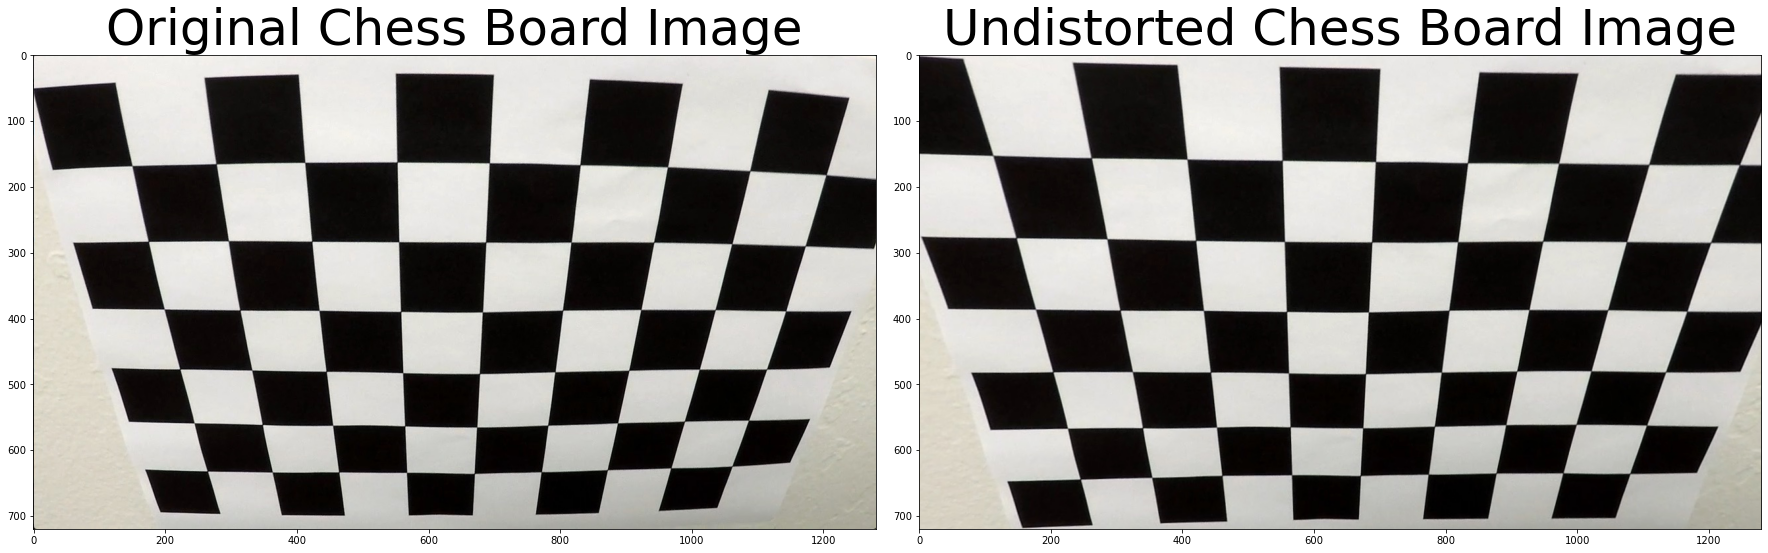

In [3]:
img = mpimg.imread('camera_cal/calibration2.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
#cv2.imshow('undistorted',undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Chess Board Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Chess Board Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Distortion Correction on test images

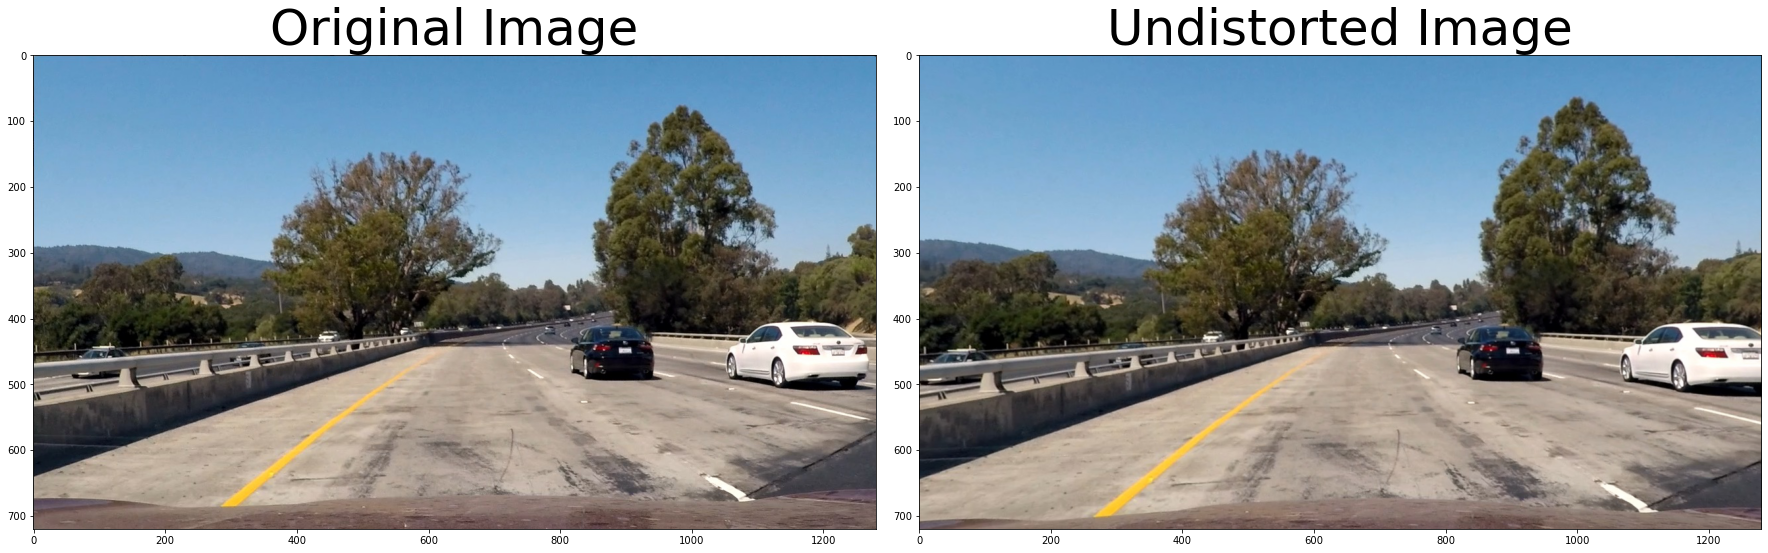

In [4]:
img_test = mpimg.imread('test_images/test1.jpg')
undist_test = cal_undistort(img_test, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_test)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline to create a thresholded binary image 

In [5]:
# Edit this function to create your own pipeline.
def pipeline_thresh_bin(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the s channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.zeros_like(sobelx)
    #combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    color_binary = np.dstack((np.zeros_like(sxbinary),sxbinary,s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #return color_binary
    return (color_binary,combined_binary)

## Thresholded Binary Image out from the pipeline

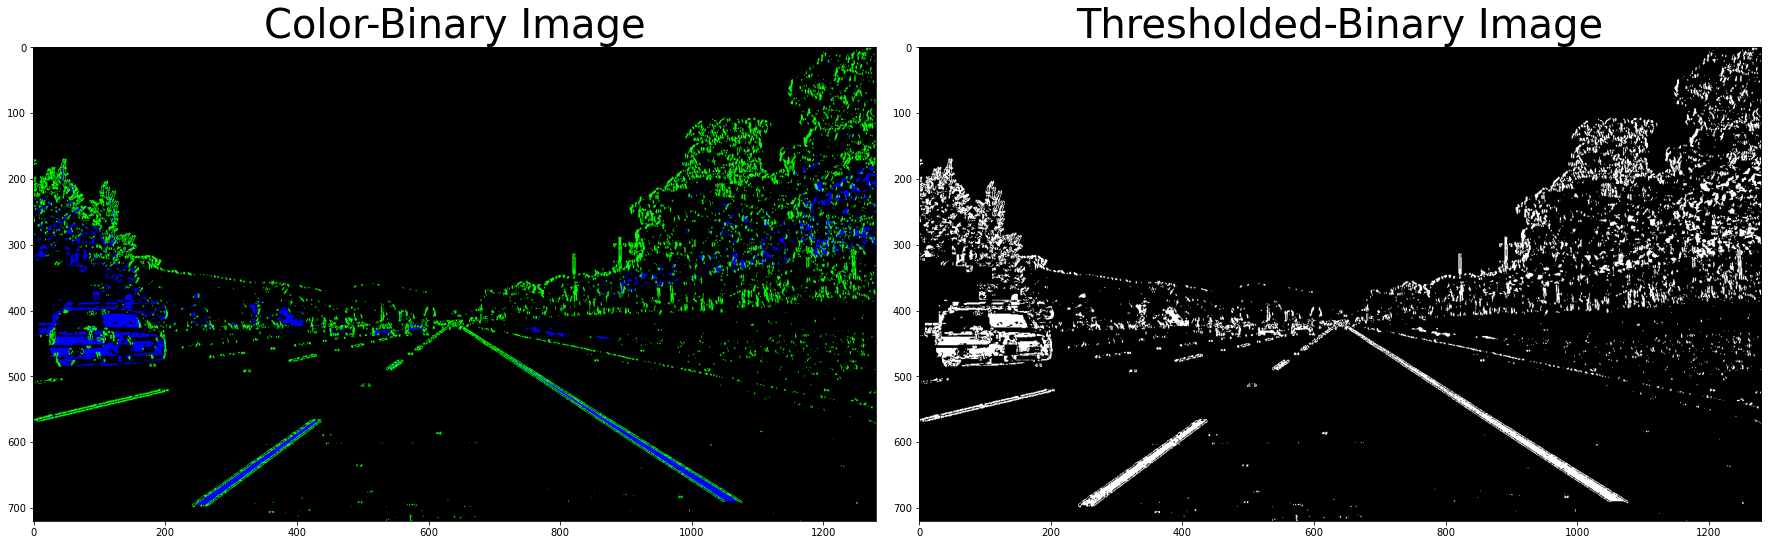

In [6]:
image = mpimg.imread('test_images/straight_lines2.jpg')
undist_image = cal_undistort(image, objpoints, imgpoints)
    
color_bin,thresh_bin = pipeline_thresh_bin(undist_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_bin)
ax1.set_title('Color-Binary Image', fontsize=40)

ax2.imshow(thresh_bin, cmap='gray')
ax2.set_title('Thresholded-Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Selecting 4 points on the binary image to warp the image

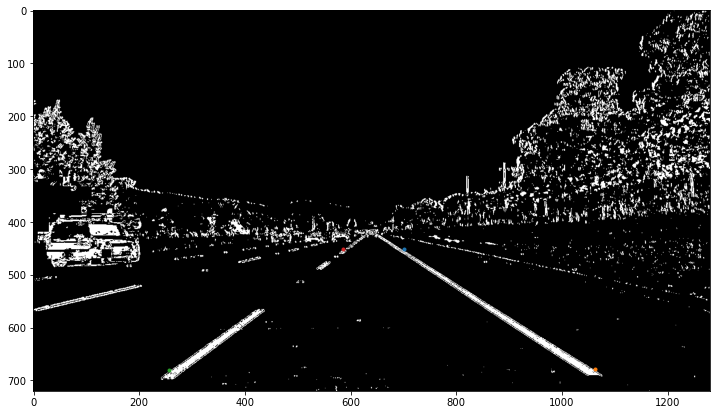

In [7]:
f, (ax1)=plt.subplots(1, 1, figsize=(20, 7))
plt.imshow(thresh_bin, cmap='gray')
plt.plot(701,451,'.')
plt.plot(1062,678,'.')
plt.plot(256,681,'.')
plt.plot(586,451,'.')

## Function to warp an image using Perspective transform

In [8]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[701,451],
    [1062,678],
    [256,681],
    [586,451]])
    
    dst = np.float32(
    [[1065,0],
    [1065,714],
    [265,714],
    [265,0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

## Birds-eye View

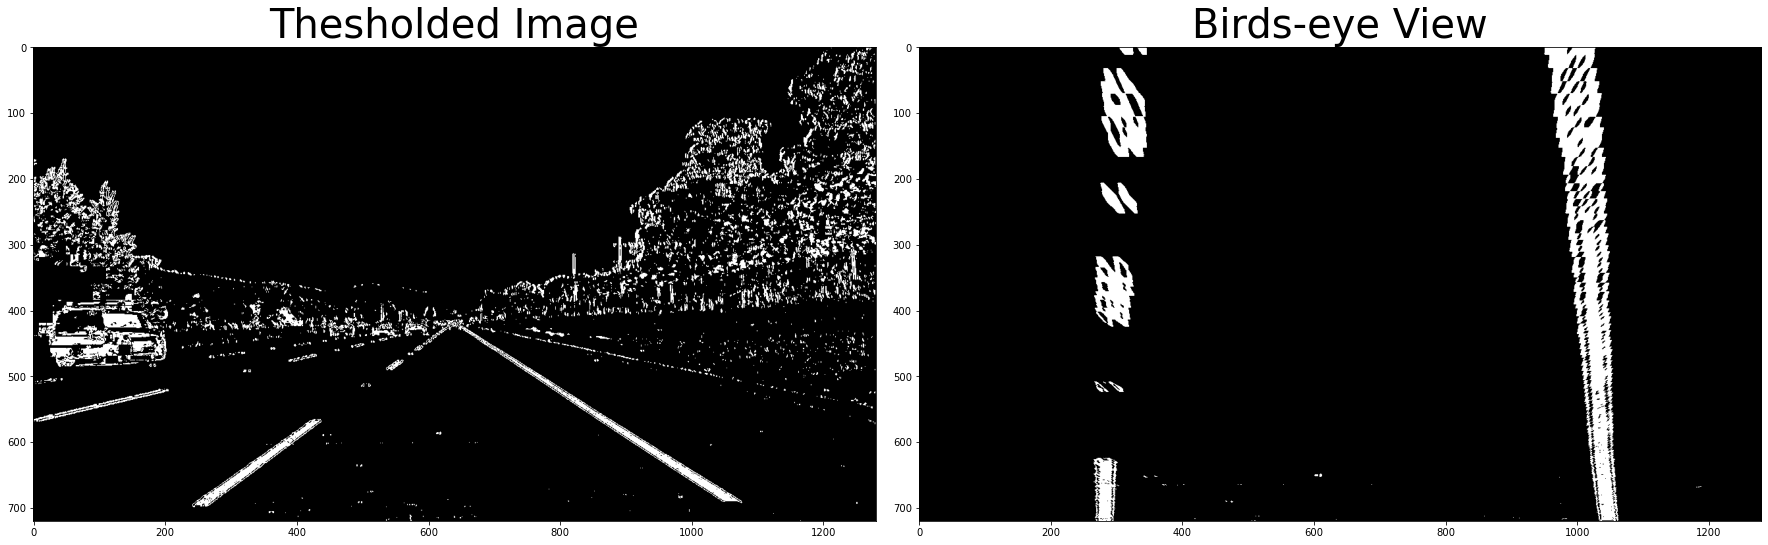

In [9]:
warped_image = warp(thresh_bin)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(thresh_bin, cmap='gray')
ax1.set_title('Thesholded Image', fontsize=40)

ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Birds-eye View', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Histogram of the warped image showing the peaks at left & right lane positions

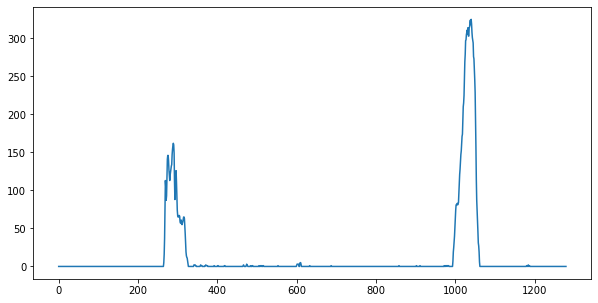

In [10]:
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
f, (ax1)=plt.subplots(1, 1, figsize=(10, 5))
plt.plot(histogram)

## Function to find lane line pixels and fit them with a second order polynomial

In [11]:
def find_fit_lanes(img):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #binary_warped = warp(pipeline(cal_undistort(mpimg.imread('../test_images/test3.jpg'), objpoints, imgpoints)))
    binary_warped = img
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img_win = out_img
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return (left_fit,right_fit,leftx,rightx,left_fitx, right_fitx, ploty,out_img_win, result)

## Lane fitted output of a curved lane

(720.0, 0.0)

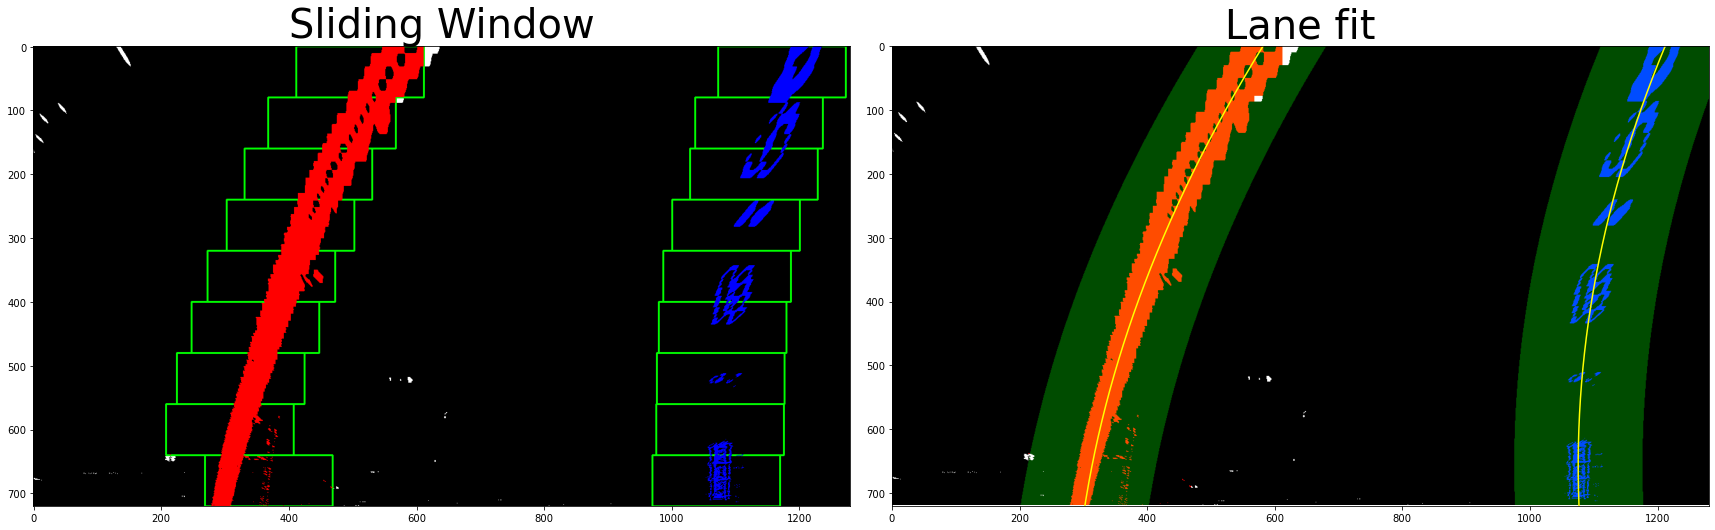

In [12]:
color_bin,thresh_bin = pipeline_thresh_bin((cal_undistort(mpimg.imread('test_images/test3.jpg'), objpoints, imgpoints)))
warped_img = warp(thresh_bin)
left_fit,right_fit,leftx,rightx,left_fitx, right_fitx, ploty,out_img_win,out_img = find_fit_lanes(warped_img)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Sliding Window', fontsize=40)
ax1.imshow(out_img_win)
ax2.set_title('Lane fit', fontsize=40)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Warp the lane boundaries back onto the original image using inverse perpective matrix

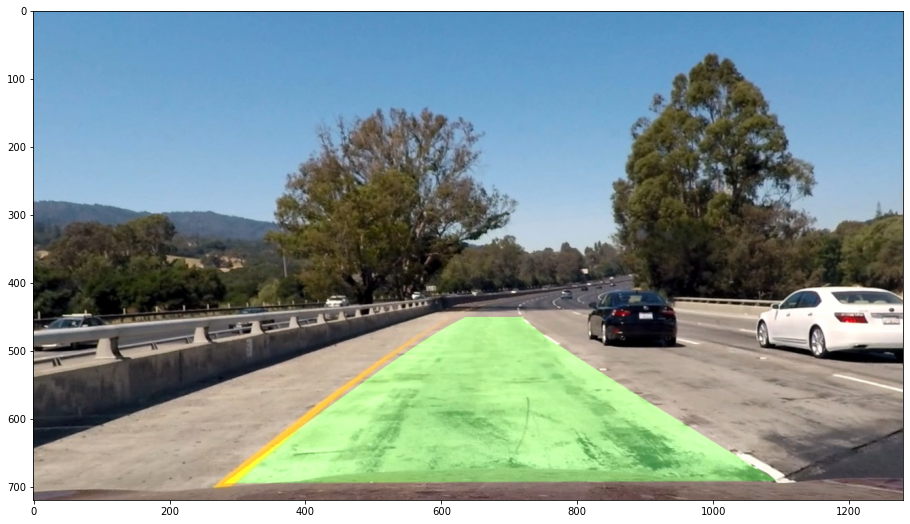

In [13]:
# Create an image to draw the lines on
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)
warp_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
src = np.float32(
    [[701,451],
    [1062,678],
    [262,681],
    [593,451]])
    
dst = np.float32(
    [[1065,0],
    [1065,714],
    [265,714],
    [265,0]])
Minv = cv2.getPerspectiveTransform(dst, src)
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_test, 1, newwarp, 0.3, 0)
f, (ax1)=plt.subplots(1, 1, figsize=(20, 9))
plt.imshow(result)
#print(result.shape[1]//2)

## Radius of Curvature in Pixel Space

In [14]:
# Define y-value where we want radius of curvature
# Choosing the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print('Radius of Left Curvature in pixel space=',left_curverad,';', 'Radius of Right Curvature in pixel space=',right_curverad)

Radius of Left Curvature in pixel space= 1631.3383564280584 ; Radius of Right Curvature in pixel space= 1589.884495220502


## Radius of Curvature in meters

In [15]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Radius of Left Curvature =',left_curverad,'m;', 'Radius of Right Curvature =',right_curverad,'m')
# Example values: 632.1 m    626.2 m

Radius of Left Curvature = 516.4644329642919 m; Radius of Right Curvature = 521.0329842816053 m


## Defining a function to calculate Radius of Curvature and offset

In [16]:
def rad_curv(ploty,left_fitx,right_fitx,img_center):    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    lane_x = right_fitx - left_fitx
    center_x = (lane_x / 2.0) + left_fitx
    cms_per_pixel = 3.7 / lane_x   # US regulation lane width = 3.7m
    offset = (center_x - img_center) * xm_per_pix
    #print(np.mean(offset))
    offset = np.mean(offset * 100.0)
    return left_curverad,right_curverad,offset

## Function to warp detected lane boundaries back onto the original image, paint the lane area and display the lane curvature & offset values 

In [17]:
def draw_lane_area(undist_test,left_fitx, right_fitx, ploty,warped_final,offset,left_curverad,right_curverad):    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_final).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    src = np.float32(
        [[701,451],
        [1062,678],
        [262,681],
        [593,451]])

    dst = np.float32(
        [[1065,0],
        [1065,714],
        [265,714],
        [265,0]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_test, 1, newwarp, 0.3, 0)
    direction = 'left' if offset < 0 else 'right'
    cv2.putText(result, 'Radius of Left Curvature = %d(m)' % left_curverad, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Radius of Right Curvature = %d(m)' % right_curverad, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle distance from center = %d(cm) %s' % (np.absolute(offset), direction), (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return result

## Pipeline to undistort the image, find threshold, apply perspective transform, find & fit lane lines and warp the detected lines back onto the original image

In [18]:
def process_image(image):
    # final output (lane area drawn on the original image)
    img_pip = image
    undistorted_final = cal_undistort(img_pip, objpoints, imgpoints)
    color_bin,bin_thresh_final = pipeline_thresh_bin(undistorted_final)
    warped_final = warp(bin_thresh_final)
    left_fit,right_fit,leftx,rightx,left_fitx, right_fitx, ploty,out_win,out_img_final = find_fit_lanes(warped_final)
    left_curverad,right_curverad,offset = rad_curv(ploty,left_fitx,right_fitx,img_center=(image.shape[1]//2))
    result = draw_lane_area(undistorted_final,left_fitx, right_fitx, ploty,warped_final,offset,left_curverad,right_curverad)
    return result

## Testing the output of the pipeline

In [27]:
pip_img = (mpimg.imread('test_images/harman_dashcam_image-old.jpg'))
final = process_image(pip_img)
f, (ax1)=plt.subplots(1, 1, figsize=(20, 9))
plt.imshow(final)

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-h4wtvo23\opencv\modules\core\src\arithm.cpp:669: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


## Video Processing

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
white_output = 'test_output/dashcam_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip('../project_video.mp4').subclip(1,6)
clip1 = VideoFileClip('dashcam.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                             | 0/420 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_output/dashcam_video_output.mp4.
Moviepy - Writing video test_output/dashcam_video_output.mp4



Moviepy - Done !
Moviepy - video ready test_output/dashcam_video_output.mp4
Wall time: 8min 50s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))